# Regression with an Insurance Dataset
## 1- download the dataset and import libraries

In [1]:
# # download the dataset from kaggle:
# ! kaggle competitions download -c playground-series-s4e12
# # unzip the dataset:
# # ! unzip titanic.zip # this works for linux only
# ! powershell -Command "Expand-Archive -Path 'playground-series-s4e12.zip'" # this works for windows only

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
train_df = pd.read_csv('playground-series-s4e12/train.csv')
test_df = pd.read_csv('playground-series-s4e12/test.csv')
train_df.describe()




,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1.200000e+06,1.181295e+06,1.155051e+06,1.090328e+06,1.125924e+06,835971.000000,1.199994e+06,1.062118e+06,1.199999e+06,1.200000e+06
mean,5.999995e+05,4.114556e+01,3.274522e+04,2.009934e+00,2.561391e+01,1.002689,9.569889e+00,5.929244e+02,5.018219e+00,1.102545e+03
std,3.464103e+05,1.353995e+01,3.217951e+04,1.417338e+00,1.220346e+01,0.982840,5.776189e+00,1.499819e+02,2.594331e+00,8.649989e+02
min,0.000000e+00,1.800000e+01,1.000000e+00,0.000000e+00,2.012237e+00,0.000000,0.000000e+00,3.000000e+02,1.000000e+00,2.000000e+01
25%,2.999998e+05,3.000000e+01,8.001000e+03,1.000000e+00,1.591896e+01,0.000000,5.000000e+00,4.680000e+02,3.000000e+00,5.140000e+02
50%,5.999995e+05,4.100000e+01,2.391100e+04,2.000000e+00,2.457865e+01,1.000000,1.000000e+01,5.950000e+02,5.000000e+00,8.720000e+02
75%,8.999992e+05,5.300000e+01,4.463400e+04,3.000000e+00,3.452721e+01,2.000000,1.500000e+01,7.210000e+02,7.000000e+00,1.509000e+03
max,1.199999e+06,6.400000e+01,1.499970e+05,4.000000e+00,5.897591e+01,9.000000,1.900000e+01,8.490000e+02,9.000000e+00,4.999000e+03


In [4]:
train_df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [5]:

print("\nNumber of NaN values in each column:")
for i, col in enumerate(train_df.columns):
    print(f"{i+1}. {col}: {train_df[col].isna().sum()}")



Number of NaN values in each column:
1. id: 0
2. Age: 18705
3. Gender: 0
4. Annual Income: 44949
5. Marital Status: 18529
6. Number of Dependents: 109672
7. Education Level: 0
8. Occupation: 358075
9. Health Score: 74076
10. Location: 0
11. Policy Type: 0
12. Previous Claims: 364029
13. Vehicle Age: 6
14. Credit Score: 137882
15. Insurance Duration: 1
16. Policy Start Date: 0
17. Customer Feedback: 77824
18. Smoking Status: 0
19. Exercise Frequency: 0
20. Property Type: 0
21. Premium Amount: 0


## 2- preprocessing


In [6]:
def preprocess_data(df):
    # 1-Drop ID column
    df = df.drop('id', axis=1)
    
    # 2-Convert age into numeric classes and handle NaN values
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min()) * 2 - 1  # Normalize age to be between -1 and 1
    
    # 3-Convert gender to binary (-1,1)
    df['Gender'] = df['Gender'].map({'Female': -1, 'Male': 1})
    
    # 4-Convert Annual Income into classes and handle NaN values
    df['Annual Income'] = df['Annual Income'].fillna(df['Annual Income'].mean())
    # df['Annual Income'] = (df['Annual Income'] - df['Annual Income'].min()) / (df['Annual Income'].max() - df['Annual Income'].min()) * 2 - 1
    
    # 5-Convert Marital Status into three classes (-1,0,1) and handle NaN values
    df['Marital Status'] = df['Marital Status'].fillna('Single')
    df['Marital Status'] = df['Marital Status'].map({'Single': -1, 'Married': 0, 'Divorced': 1})

    # 6-Handle NAN in number of dependents and convert to numeric
    df['Number of Dependents'] = df['Number of Dependents'].fillna(0)
    df['Number of Dependents'] = pd.to_numeric(df['Number of Dependents'])
    df['Number of Dependents'] = (df['Number of Dependents'] - df['Number of Dependents'].min()) / (df['Number of Dependents'].max() - df['Number of Dependents'].min()) * 2 - 1
    
    # 7-Convert Education Level into four classes (-1,-0.33,0.33,1)
    df['Education Level'] = df['Education Level'].map({'High School': -1, "Bachelor's": -0.33, "Master's": 0.33, 'PhD': 1})

    # 8-Drop Occupation column due to excessive NaN values
    df = df.drop('Occupation', axis=1)

    # 9-Convert Health Score into numbers and dividing by 10 and handle NaN values
    df['Health Score'] = df['Health Score'].fillna(df['Health Score'].mean())
    df['Health Score'] = df['Health Score'].astype(float) / 10
    df['Health Score'] = (df['Health Score'] - df['Health Score'].min()) / (df['Health Score'].max() - df['Health Score'].min()) * 2 - 1
    
    # 10-Convert Location into three classes (-1,0,1) and handle NaN values
    df['Location'] = df['Location'].fillna(df['Location'].mode()[0])
    df['Location'] = df['Location'].map({'Urban': -1, 'Rural': 0, 'Suburban': 1})

    # 11-Convert Policy Type into three classes (-1,0,1)
    df['Policy Type'] = df['Policy Type'].map({'Basic': -1, 'Comprehensive': 0, 'Premium': 1})
    
    # 12-Drop Previous Claims column due to excessive NaN values
    df = df.drop('Previous Claims', axis=1)

    # 13-Handle Vehicle Age NaN values and convert to numeric
    df['Vehicle Age'] = df['Vehicle Age'].fillna(df['Vehicle Age'].mean())
    df['Vehicle Age'] = pd.to_numeric(df['Vehicle Age'])
    df['Vehicle Age'] = (df['Vehicle Age'] - df['Vehicle Age'].min()) / (df['Vehicle Age'].max() - df['Vehicle Age'].min()) * 2 - 1

    # 14-Handle Credit Score NaN values and normalize by dividing by 200
    df['Credit Score'] = df['Credit Score'].fillna(df['Credit Score'].mean())
    df['Credit Score'] = (df['Credit Score'] - df['Credit Score'].min()) / (df['Credit Score'].max() - df['Credit Score'].min()) * 2 - 1
    
    # 15-Handle NaN values in Insurance Duration and convert to numeric
    df['Insurance Duration'] = df['Insurance Duration'].fillna(df['Insurance Duration'].mean())
    df['Insurance Duration'] = pd.to_numeric(df['Insurance Duration'])
    df['Insurance Duration'] = (df['Insurance Duration'] - df['Insurance Duration'].min()) / (df['Insurance Duration'].max() - df['Insurance Duration'].min()) * 2 - 1

    # 16-Drop Policy start date
    df = df.drop('Policy Start Date', axis=1)

    # 17-Drop Customer Feedback
    df = df.drop('Customer Feedback', axis=1)

    # 18-Convert smoking status into binary (-1,1)
    df['Smoking Status'] = df['Smoking Status'].map({'No': -1, 'Yes': 1})
    
    # 19-Convert Exercise Frequency into four classes (-1,-0.33,0.33,1)
    df['Exercise Frequency'] = df['Exercise Frequency'].map({'Rarely': -1, 'Monthly': -0.33, 'Weekly': 0.33, 'Daily': 1})
    
    # 20-Convert property type into three classes (-1,0,1)
    df['Property Type'] = df['Property Type'].map({'Apartment': -1, 'Condo': 0, 'House': 1})

    # **features engineering**
    # 1-merge features
    # Create healthy feature (exercise score minus smoking penalty plus health score)
    df['healthy'] = (df['Exercise Frequency'].astype(float) - df['Smoking Status'].astype(float) + df['Health Score'].astype(float))/3.
  
    # Drop original features
    df = df.drop(['Health Score','Smoking Status', 'Exercise Frequency'], axis=1)

 
    
    return df


# Apply preprocessing to both train and test datasets
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)


print("Processed training data shape:", train_processed.shape)
print("\nFirst few rows of processed training data:")
print(train_processed.head())

train_processed.describe()





Processed training data shape: (1200000, 14)

First few rows of processed training data:
        Age  Gender  Annual Income  Marital Status  Number of Dependents  \
0 -0.956522      -1        10049.0               0                  -0.5   
1 -0.086957      -1        31678.0               1                   0.5   
2 -0.782609       1        25602.0               1                   0.5   
3 -0.869565       1       141855.0               0                   0.0   
4 -0.869565       1        39651.0              -1                  -0.5   

   Education Level  Location  Policy Type  Vehicle Age  Credit Score  \
0            -0.33        -1            1     0.789474     -0.737705   
1             0.33         0            0     0.263158      0.435337   
2            -1.00         1            1     0.473684      0.067120   
3            -0.33         0           -1    -1.000000     -0.755920   
4            -0.33         0            1    -0.157895      0.085610   

   Insurance Duration

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Location,Policy Type,Vehicle Age,Credit Score,Insurance Duration,Property Type,Premium Amount,healthy
count,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06,1.200000e+06
mean,6.328832e-03,4.285000e-03,3.274522e+04,-1.846333e-02,-8.688042e-02,1.188227e-02,3.359167e-03,2.743333e-03,7.356703e-03,6.711967e-02,4.554795e-03,3.091667e-04,1.102545e+03,-5.891989e-02
std,5.840873e-01,9.999912e-01,3.157107e+04,8.191843e-01,7.349696e-01,7.409943e-01,8.160066e-01,8.166964e-01,6.080183e-01,5.140346e-01,6.485826e-01,8.166637e-01,8.649989e+02,4.380053e-01
min,-1.000000e+00,-1.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,2.000000e+01,-1.000000e+00
25%,-4.782609e-01,-1.000000e+00,8.646000e+03,-1.000000e+00,-1.000000e+00,-3.300000e-01,-1.000000e+00,-1.000000e+00,-4.736842e-01,-3.296903e-01,-5.000000e-01,-1.000000e+00,5.140000e+02,-3.980613e-01
50%,6.328832e-03,1.000000e+00,2.499600e+04,0.000000e+00,0.000000e+00,3.300000e-01,0.000000e+00,0.000000e+00,5.263158e-02,6.711967e-02,0.000000e+00,0.000000e+00,8.720000e+02,-5.711438e-02
75%,5.217391e-01,1.000000e+00,4.393600e+04,1.000000e+00,5.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,5.789474e-01,4.790528e-01,5.000000e-01,1.000000e+00,1.509000e+03,2.710300e-01
max,1.000000e+00,1.000000e+00,1.499970e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.999000e+03,9.989481e-01


In [7]:
print("\nNumber of NaN values in each column:")
for i, col in enumerate(train_processed.columns):
    dtype = train_processed[col].dtype
    print(f"{i+1}. {col} ({dtype}): {train_processed[col].isna().sum()}")
    


Number of NaN values in each column:
1. Age (float64): 0
2. Gender (int64): 0
3. Annual Income (float64): 0
4. Marital Status (int64): 0
5. Number of Dependents (float64): 0
6. Education Level (float64): 0
7. Location (int64): 0
8. Policy Type (int64): 0
9. Vehicle Age (float64): 0
10. Credit Score (float64): 0
11. Insurance Duration (float64): 0
12. Property Type (int64): 0
13. Premium Amount (float64): 0
14. healthy (float64): 0


In [8]:
# Split features and target for premium prediction
y_train = train_processed['Premium Amount']
X_train = train_processed.drop(['Premium Amount'], axis=1)

def classify_annual_income(annual_income):
    cs_min = 1
    cs_max = 150000
   
    if annual_income < cs_min + 0.056* (cs_max - cs_min):
        return 0
    elif annual_income < cs_min + 0.17* (cs_max - cs_min):
        return 1
    elif annual_income < cs_min + 0.3* (cs_max - cs_min):
        return 2
    else:
        return 3
y_self_supervised = X_train['Annual Income'].apply(classify_annual_income)
X_train.drop('Annual Income', axis=1)
# def classify_credit_score(credit_score):
#     cs_min = 300
#     cs_max = 850
   
#     if credit_score < cs_min + 0.34* (cs_max - cs_min):
#         return 0
#     elif credit_score < cs_min + 0.54* (cs_max - cs_min):
#         return 1
#     elif credit_score < cs_min + 0.75* (cs_max - cs_min):
#         return 2
#     else:
#         return 3
# y_self_supervised = X_train['Credit Score'].apply(classify_credit_score)
# X_train.drop('Credit Score', axis=1)
# def classify_premium_amount(premium_amount):
#     cs_min = 20
#     cs_max = 5000
   
#     if premium_amount < cs_min + 0.1 * (cs_max - cs_min):
#         return 0
#     elif premium_amount < cs_min + 0.17 * (cs_max - cs_min):
#         return 1
#     elif premium_amount < cs_min + 0.3 * (cs_max - cs_min):
#         return 2
#     else:
#         return 3

# y_self_supervised = y_train.apply(classify_premium_amount)
print("\nFeature matrix shape:", X_train.shape)
print("\nTest feature matrix shape:", test_processed.shape)
print("Premium target shape:", y_train.shape) 
print("Self-supervised target shape:", y_self_supervised.shape)
class_counts = y_self_supervised.value_counts(normalize=True) * 100
print("\nPercentage of y_self_supervised in each class:")
for class_label, percentage in class_counts.items():
    print(f"Class {class_label}: {percentage:.2f}%")


Feature matrix shape: (1200000, 13)

Test feature matrix shape: (800000, 13)
Premium target shape: (1200000,)
Self-supervised target shape: (1200000,)

Percentage of y_self_supervised in each class:
Class 2: 26.08%
Class 1: 25.92%
Class 0: 24.86%
Class 3: 23.15%


In [9]:
# Check for NaN/infinite values in features
print("\nChecking for NaN/infinite values in features:")
nan_counts = X_train.isna().sum()
inf_counts = np.isinf(X_train).sum()
if nan_counts.sum() > 0 or inf_counts.sum() > 0:
    print("Warning: Found NaN or infinite values in features:")
    for col in X_train.columns:
        if nan_counts[col] > 0:
            print(f"- {col}: {nan_counts[col]} NaN values")
        if inf_counts[col] > 0:
            print(f"- {col}: {inf_counts[col]} infinite values")
    raise ValueError("NaN or infinite values found in features. Please handle these before training.")

# Check for NaN/infinite values in target
print("\nChecking for NaN/infinite values in target:")
if np.any(np.isnan(y_self_supervised)) or np.any(np.isinf(y_self_supervised)):
    nan_count = np.isnan(y_self_supervised).sum()
    inf_count = np.isinf(y_self_supervised).sum()
    print(f"Found {nan_count} NaN values and {inf_count} infinite values in target")
    raise ValueError("NaN or infinite values found in target. Please handle these before training.")

# Check for zero variance features
print("\nChecking for zero variance features:")
variances = X_train.var()
zero_var_features = variances[variances == 0].index
if len(zero_var_features) > 0:
    print("Warning: Found features with zero variance:")
    print(zero_var_features.tolist())
    raise ValueError("Zero variance features found. These features should be removed.")

print("\nAll checks passed. Data is ready for training.")



Checking for NaN/infinite values in features:

Checking for NaN/infinite values in target:

Checking for zero variance features:

All checks passed. Data is ready for training.


## 3- self-supervised learning model


Epoch 1/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.3827 - loss: 71.6556 - val_accuracy: 0.7967 - val_loss: 0.6497
Epoch 2/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6237 - loss: 0.8584 - val_accuracy: 0.6618 - val_loss: 0.5734
Epoch 3/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7250 - loss: 0.5934 - val_accuracy: 0.7000 - val_loss: 0.6462
Epoch 4/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7297 - loss: 0.5388 - val_accuracy: 0.6599 - val_loss: 0.9814
Epoch 5/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7326 - loss: 0.5221 - val_accuracy: 0.7125 - val_loss: 0.8376
Epoch 6/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7309 - loss: 0.5232 - val_accuracy: 0.6664 - val_loss: 1.0904
Epoch 7/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7254 - loss: 0.5357 - val_accuracy: 0.6761 - val_loss: 0.9946
Epoch 8/150
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7246 - loss: 

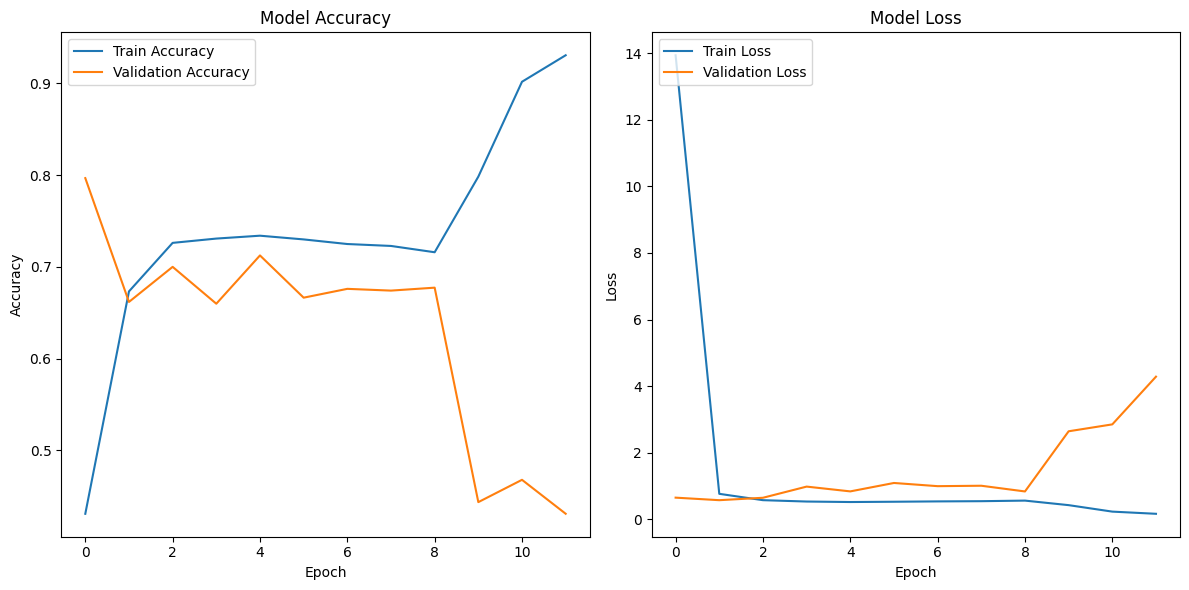

In [10]:


# Define the base model for multi-class classification with improved architecture
base_model = Sequential()
base_model.add(Input(shape=(X_train.shape[1],)))  # Input layer
base_model.add(Dense(256, activation='relu'))        # Increased hidden layer with 256 neurons
base_model.add(Dropout(0.3))                         # Increased dropout rate for regularization
base_model.add(Dense(128, activation='relu'))        # Hidden layer with 128 neurons
base_model.add(Dropout(0.3))                         # Another dropout layer for regularization
base_model.add(Dense(64, activation='relu'))         # Hidden layer with 64 neurons
base_model.add(Dense(4, activation='softmax'))       # Output layer for multi-class classification

# Compile the model with a learning rate scheduler
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model on the training data with increased epochs and smaller batch size
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_self_supervised, test_size=0.2, random_state=42)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model on the training data with the new validation set
history = base_model.fit(X_train_split, y_train_split, epochs=150, batch_size=256, validation_data=(X_val, y_val), callbacks=[early_stopping])

print("Improved base model for multi-class classification created.")
best_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_accuracy:.2f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()



37500/37500 ━━━━━━━━━━━━━━━━━━━━ 19s 518us/step
F-score: 0.65


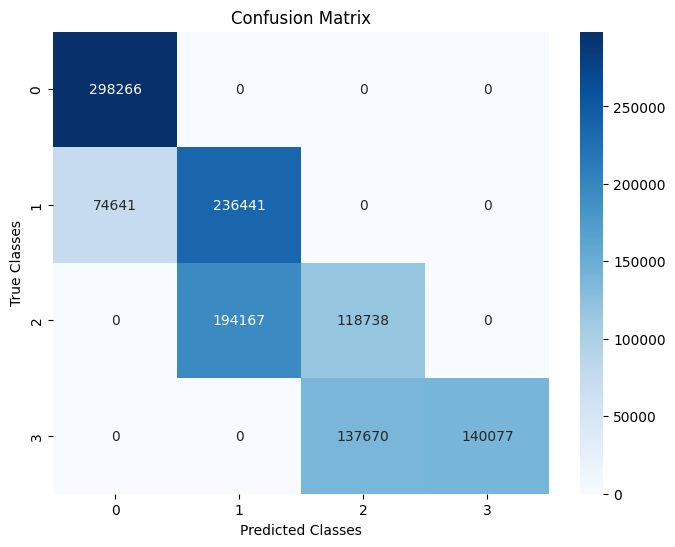

In [11]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the training data
train_predictions = base_model.predict(X_train)
train_predictions_classes = np.argmax(train_predictions, axis=1)  # Convert probabilities to class labels for multi-class classification

# Calculate F-score
f_score = f1_score(y_self_supervised, train_predictions_classes, average='weighted', labels=np.unique(y_self_supervised))
print(f"F-score: {f_score:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_self_supervised, train_predictions_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_self_supervised), yticklabels=np.unique(y_self_supervised))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()


In [12]:
# Save the trained model for transfer learning
model_save_path = 'classification_base_model.h5'
base_model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")



Model saved to: classification_base_model.h5


## 4-Use model for transfer learning to get better results


In [13]:
# Load the pre-trained model from file
base_model = tf.keras.models.load_model('classification_base_model.h5', 
                                              compile=False)
base_model.compile(optimizer='adam', 
                         loss='mse',
                         metrics=['mse'])
print("Pre-trained model loaded successfully")

# Check for data issues that could cause NaN losses
def validate_data(X, y, model_name="Data"):
    # Check for NaN/infinite values
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        raise ValueError(f"{model_name}: Input features contain NaN or infinite values")
    if np.any(np.isnan(y)) or np.any(np.isinf(y)):
        raise ValueError(f"{model_name}: Target values contain NaN or infinite values")
        
    # Check for zero/negative values that could cause log issues
    if np.any(y <= 0):
        raise ValueError(f"{model_name}: Target contains zero or negative values which will cause issues with log calculations")
        
    # Check for extreme values that could cause numerical instability
    if np.any(np.abs(X) > 1e6):
        raise ValueError(f"{model_name}: Input features contain extreme values (>1e6) that may cause numerical instability")
    if np.any(np.abs(y) > 1e6):
        raise ValueError(f"{model_name}: Target contains extreme values (>1e6) that may cause numerical instability")
        
    print(f"{model_name} validation passed")

# Validate training data
validate_data(X_train, y_train, "Training data")

# Check credit score model predictions for training data
train_preds = base_model.predict(X_train)
validate_data(train_preds, y_train, "Credit score model training predictions")

print("\nAll validation checks passed - data and model predictions look valid for transfer learning")


Pre-trained model loaded successfully
Training data validation passed
37500/37500 ━━━━━━━━━━━━━━━━━━━━ 20s 534us/step
Credit score model training predictions validation passed

All validation checks passed - data and model predictions look valid for transfer learning


New model created for regression with continuous output, using layers from the base model
Epoch 1/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 1.3228 - mae: 698.1240 - rmsle_loss: 1.3228 - val_loss: 1.0738 - val_mae: 639.6267 - val_rmsle_loss: 1.0738
Epoch 2/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - loss: 1.0781 - mae: 648.5679 - rmsle_loss: 1.0781 - val_loss: 1.0723 - val_mae: 640.5767 - val_rmsle_loss: 1.0723
Epoch 3/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - loss: 1.0799 - mae: 649.6144 - rmsle_loss: 1.0799 - val_loss: 1.0712 - val_mae: 642.0170 - val_rmsle_loss: 1.0712
Epoch 4/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - loss: 1.0776 - mae: 649.9957 - rmsle_loss: 1.0776 - val_loss: 1.0713 - val_mae: 643.1164 - val_rmsle_loss: 1.0713
Epoch 5/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step - loss: 1.0785 - mae: 649.4568 - rmsle_loss: 1.0785 - val_loss: 1.0722 - val_mae: 640.9047 - val_rmsle_loss: 1.0722
Epoch 6/10
30000/30000 ━━━━━━━━━━━━━━━━━━━━ 3

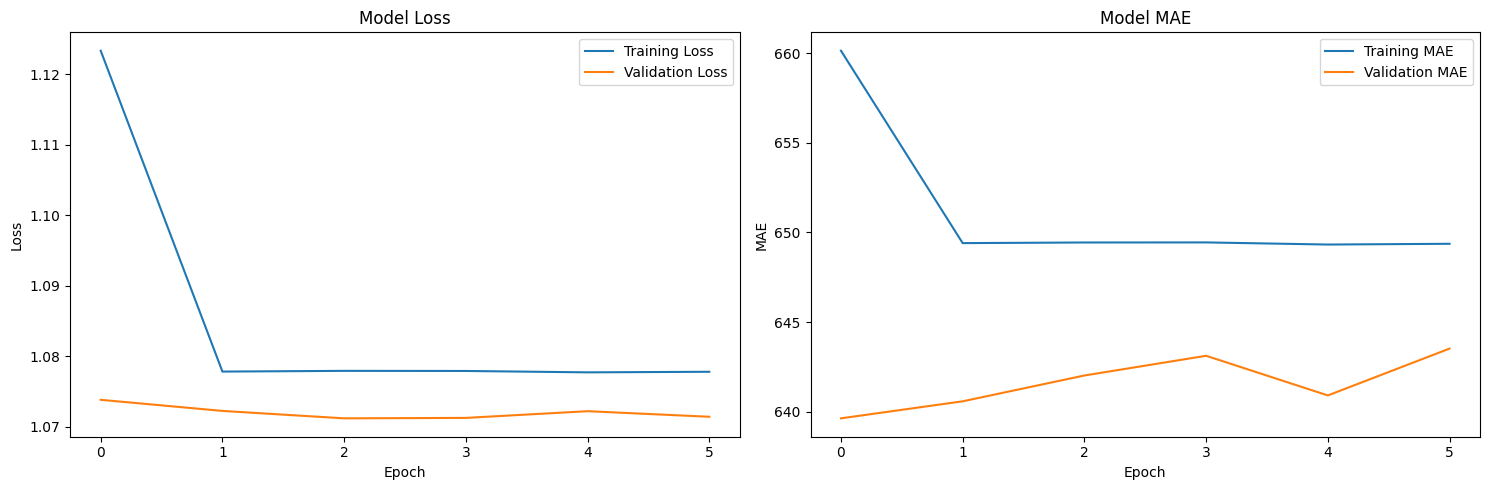

In [14]:
# Freeze the layers of the base model
base_model.trainable = False

# Create a new model starting with the layers of the base model
model = tf.keras.Sequential()
for layer in base_model.layers:
    model.add(layer)

# Add extra layers for regression
model.add(tf.keras.layers.Dense(64, activation='relu'))  # First extra layer
model.add(tf.keras.layers.Dense(32, activation='relu'))  # Second extra layer
model.add(tf.keras.layers.Dense(1, activation='linear'))  # Output layer for continuous value

# Compile the new model
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['mse'])

print("New model created for regression with continuous output, using layers from the base model")


# Custom RMSLE loss function with clipping to prevent NaN
def rmsle_loss(y_true, y_pred):
    epsilon = 1e-6
    y_pred = tf.clip_by_value(y_pred, epsilon, float('inf'))
    y_true = tf.clip_by_value(y_true, epsilon, float('inf'))
    return tf.sqrt(tf.reduce_mean(
        tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
    ))

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=rmsle_loss,
    metrics=[rmsle_loss, 'mae']
)

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Unfreeze the base model for further training
base_model.trainable = True

# Train the full model for an additional 5 epochs
history_fine_tuning = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping]
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# Save the trained transfer learning model
model.save('insurance_premium_model.h5')
print("Model saved successfully as 'insurance_premium_model.h5'")


Model saved successfully as 'insurance_premium_model.h5'


## 5- Evaluate the model


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 5s 594us/step

Validation Loss (MSE): 879622.35
Validation MAE: 647.37
Validation R-squared Score: -0.1853


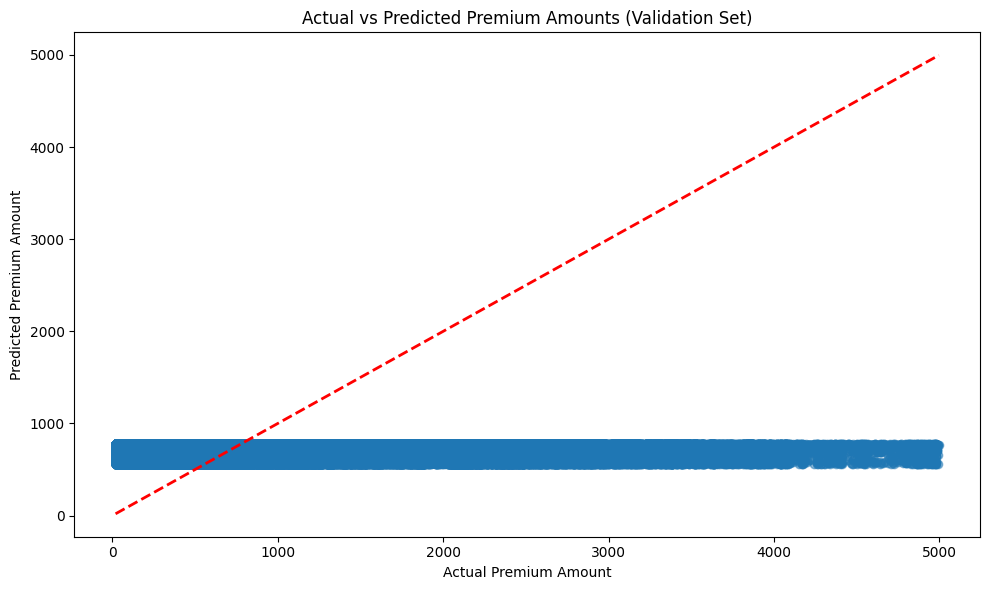

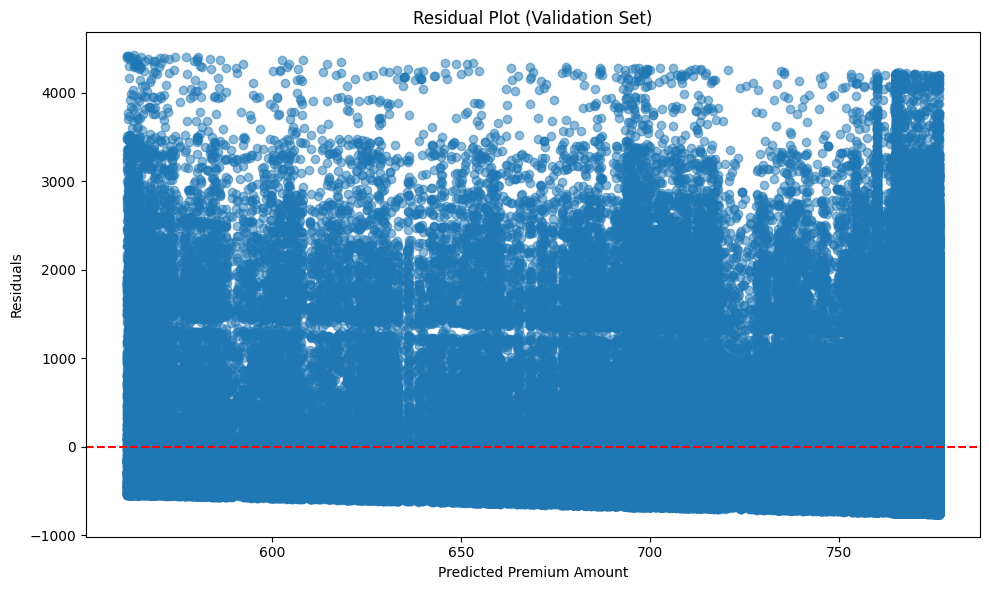

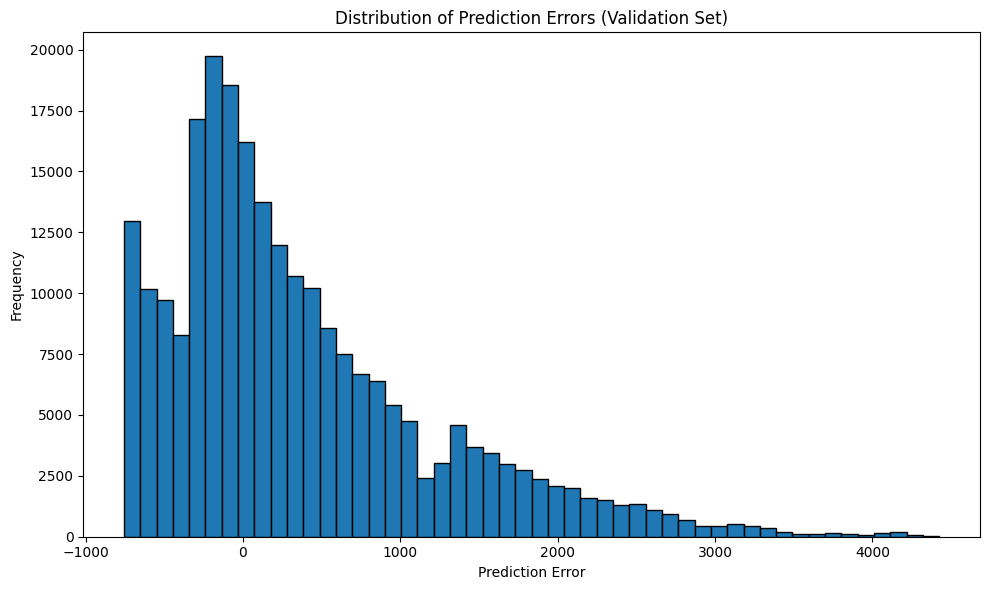

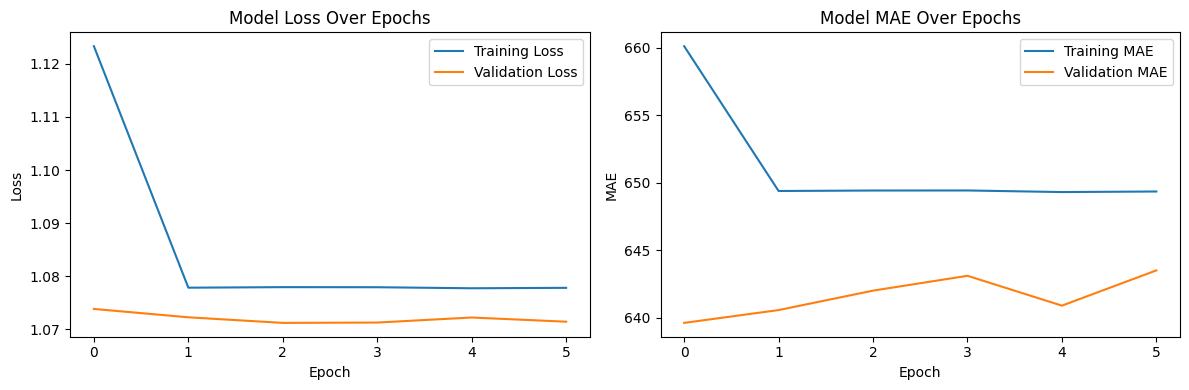

In [16]:
# Make predictions on validation data
val_predictions = model.predict(X_train[int(0.8*len(X_train)):])
val_actual = y_train[int(0.8*len(y_train)):]

# Calculate validation metrics
val_loss = mean_squared_error(val_actual, val_predictions)
val_mae = mean_absolute_error(val_actual, val_predictions)
val_r2 = r2_score(val_actual, val_predictions)

print(f"\nValidation Loss (MSE): {val_loss:.2f}")
print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation R-squared Score: {val_r2:.4f}")

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(val_actual, val_predictions, alpha=0.5)
plt.plot([val_actual.min(), val_actual.max()], [val_actual.min(), val_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Premium Amount')
plt.ylabel('Predicted Premium Amount')
plt.title('Actual vs Predicted Premium Amounts (Validation Set)')
plt.tight_layout()
plt.show()

# Plot residuals
residuals = val_actual - val_predictions.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(val_predictions.flatten(), residuals, alpha=0.5)
plt.xlabel('Predicted Premium Amount')
plt.ylabel('Residuals')
plt.title('Residual Plot (Validation Set)')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Validation Set)')
plt.tight_layout()
plt.show()

# Plot training metrics over epochs
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


## 6- Generate Results


In [17]:
# Make predictions on test data using the model
test_predictions = model.predict(test_processed)

# Create DataFrame with ID and predictions
results_df = pd.DataFrame({
    'id': test_df['id'],
    'Premium Amount': test_predictions.flatten()  # Corrected to use test_predictions
})

# Save predictions to CSV
results_df.to_csv('Submission.csv', index=False)



25000/25000 ━━━━━━━━━━━━━━━━━━━━ 14s 562us/step
